In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pylab
import scikit_posthocs as sp
# pd.options.display.float_format = '{:,.4f}'.format
from cliffs_delta import cliffs_delta
import seaborn as sns # For pairplots and heatmaps
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, mannwhitneyu

# Correlation Analyses

## Utility functions

These are utility functions for performing normality related tests.

The tests can be done using the functions `check_normality` and `check_variance_homogeneity`.

Hypotheses for `check_normality`:

- $H_0$: The data are normally distributed.
- $H_1$: The data are not normally distributed. 

Hypotheses for `check_variance_homogeneity`

- $H_0$: The variances of the samples are the same.
- $H_1$: The variances of the samples are different. 

### Effect Size
We compute the effect size using Cliff's delta statistic (Cliff 1993), a non-parametric measure that quantifies the amount of difference between two groups of observations.

We use 

`from cliffs_delta import cliffs_delta`

In [2]:
def check_normality(data):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("W = %.2f"% test_stat_normality)
    print("p value:", p_value_normality)
    if p_value_normality <0.05:
        print("Reject null hypothesis >> The data are not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data are normally distributed")

In [3]:
def check_variance_homogeneity(group1, group2):
    test_stat_var, p_value_var= stats.levene(group1,group2)
    print("p value:%.4f" % p_value_var)
    if p_value_var <0.05:
        print("Reject null hypothesis >> The variances of the samples are different.")
    else:
        print("Fail to reject null hypothesis >> The variances of the samples are same.")

In [4]:
def cohen_effect_size(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return abs((u1 - u2) / s)

## Datasets

To execute RQ1's correlation tests, it is necessary only the `bug_report_collab_dataset.csv` file which is built by the `process_csv_collab.ipynb` notebook.

In [5]:
collab_summary_df = pd.read_csv('../datasets/bug_report_collab_dataset.csv', sep=';')
collab_summary_df

,Key,ReporterId,AssigneeId,NComments,NPC,NRC,URC,NPI,NRI,URI,...,MaxCommentSize,AvgTokenNumber,MaxTokenNumber,IEI,RDI,DBR,DEC,AverageCommentsPerParticipant,MedianCommentsPerParticipant,BFT
0,HADOOP-12274,id2,id2,4,2,4,2,0.29,0.8,0.4,...,55.0,8.0,12.0,0.93,"(4,2)",25.35,-0.00,2.0,2.0,208.45
1,HDFS-12222,id976,id1484,26,6,5,4,0.86,1.0,0.8,...,817.0,41.7,126.0,0.58,"(5,6)",0.08,-0.85,5.2,3.0,1107.16
2,HADOOP-10326,id1747,id1671,12,7,5,4,1.00,1.0,0.8,...,144.0,13.7,24.0,0.58,"(5,7)",6965.27,-0.00,2.0,1.0,13188.99
3,HDFS-10424,id5,id88,9,4,5,3,0.57,1.0,0.6,...,584.0,20.3,92.0,0.67,"(5,4)",0.02,-0.00,2.2,2.0,55.95
4,YARN-2308,id416,id39,41,10,5,5,1.00,1.0,1.0,...,670.0,25.3,83.0,0.54,"(5,10)",8.90,-4597.80,4.1,2.5,2123.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10351,MAPREDUCE-795,id1741,id1741,1,1,3,1,0.14,0.6,0.2,...,20.0,3.0,3.0,1.00,"(3,1)",1819.02,-0.00,1.0,1.0,1819.02
10352,MAPREDUCE-844,id1741,-1,1,1,2,1,0.14,0.4,0.2,...,25.0,4.0,4.0,1.00,"(2,1)",1385.14,-0.00,1.0,1.0,1385.14
10353,MAPREDUCE-1291,id1741,id1741,2,1,3,1,0.14,0.6,0.2,...,286.0,25.0,46.0,1.00,"(3,1)",121.85,0.00,2.0,2.0,1418.49
10354,MAPREDUCE-2806,id1741,id1741,2,1,3,1,0.14,0.6,0.2,...,54.0,7.0,10.0,1.00,"(3,1)",0.12,-0.00,2.0,2.0,2516.45


## Preprocessing phase

### Checking normality of each metric

In [6]:
npi = collab_summary_df['NPI']
nri = collab_summary_df['NRI']
uri = collab_summary_df['URI']
iei = collab_summary_df['IEI']
bft = collab_summary_df['BFT']

As these are a large sample, the Shapiro-Wilk test can be significant even when the scores are only slightly different from a normal distribution. To plot a Q-Q plot to see if that's the case:

```
check_normality(sample)
stats.probplot(sample, dist="norm", plot=pylab)
pylab.show()
```

Checking normality of NPI
W = 0.86
p value: 0.0
Reject null hypothesis >> The data are not normally distributed


/Users/emanuele/code/si-bft/env/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


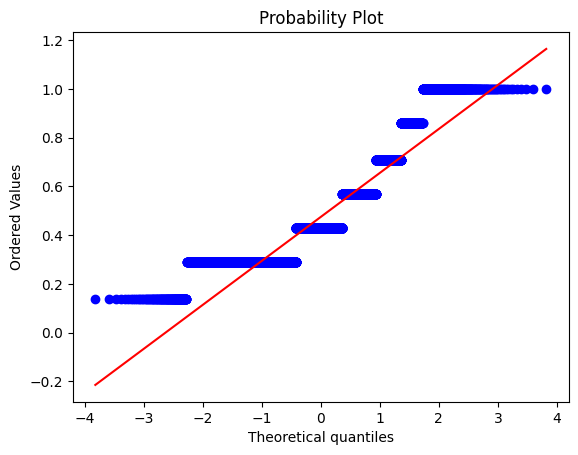

In [7]:
print("Checking normality of NPI")
check_normality(npi)
stats.probplot(npi, dist="norm", plot=pylab)
pylab.show()

Checking normality of NRI
W = 0.68
p value: 0.0
Reject null hypothesis >> The data are not normally distributed


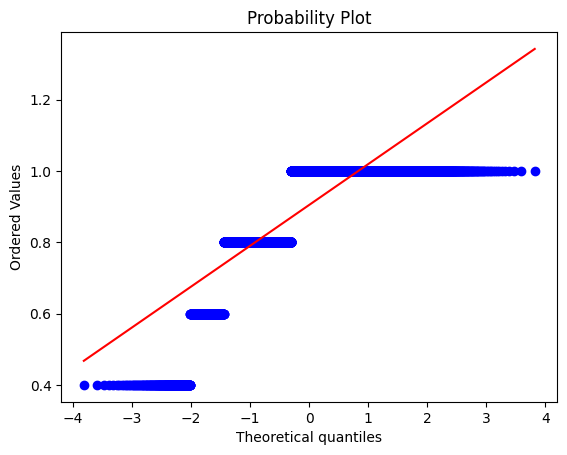

In [8]:
print("Checking normality of NRI")
check_normality(nri)
stats.probplot(nri, dist="norm", plot=pylab)
pylab.show()

Checking normality of URI
W = 0.85
p value: 0.0
Reject null hypothesis >> The data are not normally distributed


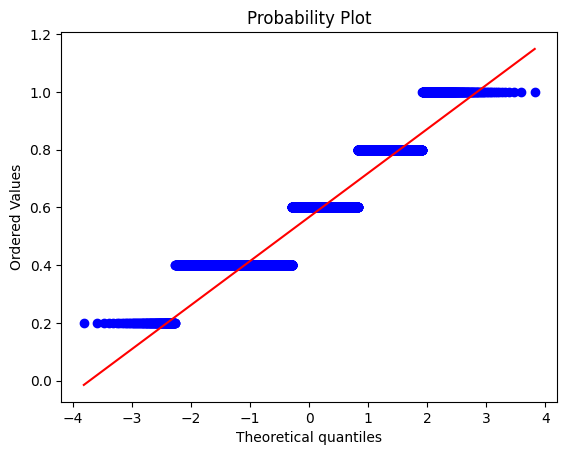

In [9]:
print("Checking normality of URI")
check_normality(uri)
stats.probplot(uri, dist="norm", plot=pylab)
pylab.show()

Checking normality of IEI
W = 0.98
p value: 1.840888217829822e-32
Reject null hypothesis >> The data are not normally distributed


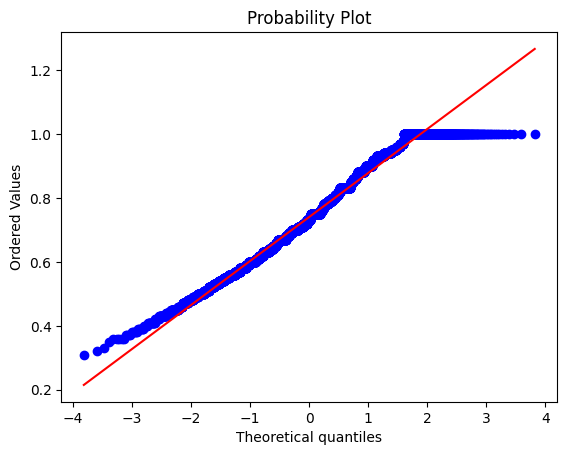

In [10]:
print("Checking normality of IEI")
check_normality(iei)
stats.probplot(iei, dist="norm", plot=pylab)
pylab.show()


Checking normality of BFT
W = 0.35
p value: 0.0
Reject null hypothesis >> The data are not normally distributed


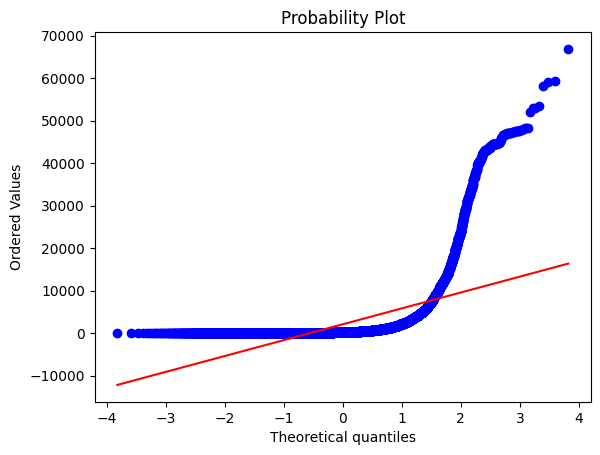

In [11]:

print("Checking normality of BFT")
check_normality(bft)
stats.probplot(bft, dist="norm", plot=pylab)
pylab.show()

## Analysis 1: Collaboration Diversity Metrics Correlations

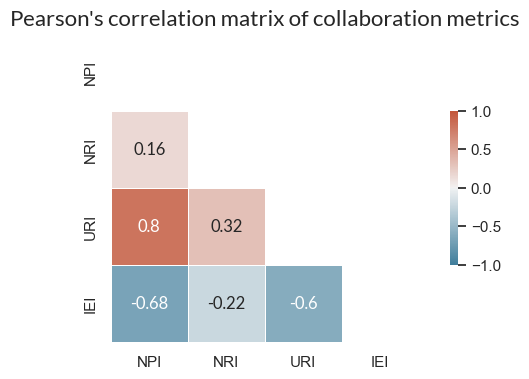

In [33]:
diversity_metrics_df = collab_summary_df[['NPI', 'NRI', 'URI', 'IEI']]

# compute correlation matrix
corr_p = diversity_metrics_df.corr()
p_values = diversity_metrics_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(diversity_metrics_df.columns))

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_p, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr_p, mask=mask,vmin=-1, vmax=1, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={'fontfamily' : 'Lato'} )

heatmap.set_title("Pearson's correlation matrix of collaboration metrics", fontdict={'fontsize':16, 'fontfamily' : 'Lato'})

plt.savefig('../visualization/images/diversity_pearson_corr.pdf', format='pdf')

In [34]:
p_values

,NPI,NRI,URI,IEI
NPI,0.000000e+00,2.616086e-63,0.000000e+00,0.000000e+00
NRI,2.616086e-63,0.000000e+00,1.724445e-242,6.453854e-114
URI,0.000000e+00,1.724445e-242,0.000000e+00,0.000000e+00
IEI,0.000000e+00,6.453854e-114,0.000000e+00,0.000000e+00


## Analysis 2: Collaboration Diversity and BFT

Let's create a matrix of all metrics + bft

Text(0.5, 1.0, 'Correlation matrix of collaboration metrics including outliers')

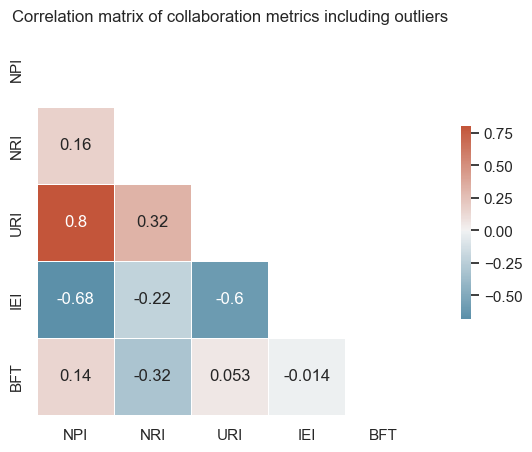

In [35]:
all_metrics_df = collab_summary_df[['NPI', 'NRI', 'URI', 'IEI', 'BFT']]

# compute corrleation matrix
corr_p = all_metrics_df.corr()

p_values = all_metrics_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(all_metrics_df.columns))

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_p, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr_p, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

heatmap.set_title('Correlation matrix of collaboration metrics including outliers')

In [36]:
p_values

,NPI,NRI,URI,IEI,BFT
NPI,0.000000e+00,2.616086e-63,0.000000e+00,0.000000e+00,9.432890e-50
NRI,2.616086e-63,0.000000e+00,1.724445e-242,6.453854e-114,1.042970e-239
URI,0.000000e+00,1.724445e-242,0.000000e+00,0.000000e+00,7.089854e-08
IEI,0.000000e+00,6.453854e-114,0.000000e+00,0.000000e+00,1.572126e-01
BFT,9.432890e-50,1.042970e-239,7.089854e-08,1.572126e-01,0.000000e+00


<Axes: >

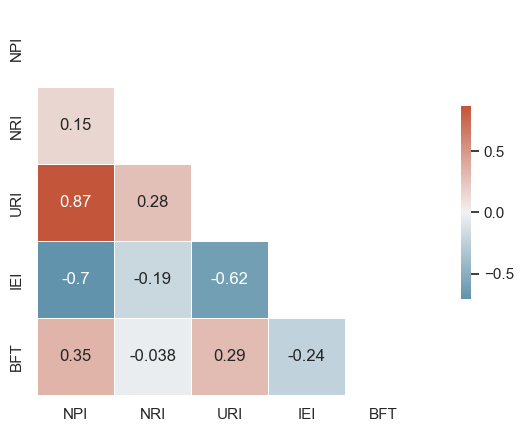

In [15]:
corr_s = all_metrics_df.corr(method='spearman')

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_s, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_s, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Let's filter out BFT outliers


In [16]:
 #calculate interquartile range 
q3, q1 = np.percentile(all_metrics_df['BFT'], [75 ,25])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

filtered_df = all_metrics_df[(all_metrics_df['BFT'] > lower_bound) & (all_metrics_df['BFT'] < upper_bound)]
print("Number of outliers in BFT: ", len(all_metrics_df) - len(filtered_df))

Lower bound:  -1299.99125
Upper bound:  2275.03875
Number of outliers in BFT:  1582


In [17]:
# filtering using z-scores
filtered_df_z = all_metrics_df[np.abs(stats.zscore(all_metrics_df['BFT'])) < 3]
print("Number of outliers in BFT using z-scores: ", len(all_metrics_df) - len(filtered_df_z))

Number of outliers in BFT using z-scores:  270


<Axes: >

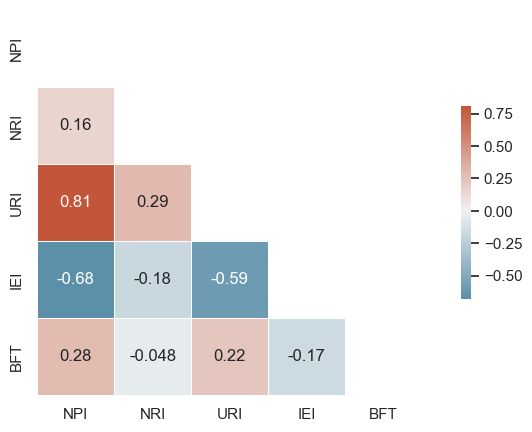

In [18]:
# compute corrleation matrix
corr_p = filtered_df_z.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_p, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_p, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## Analysis 3: Collaboration Diversity, BFT and other size metrics

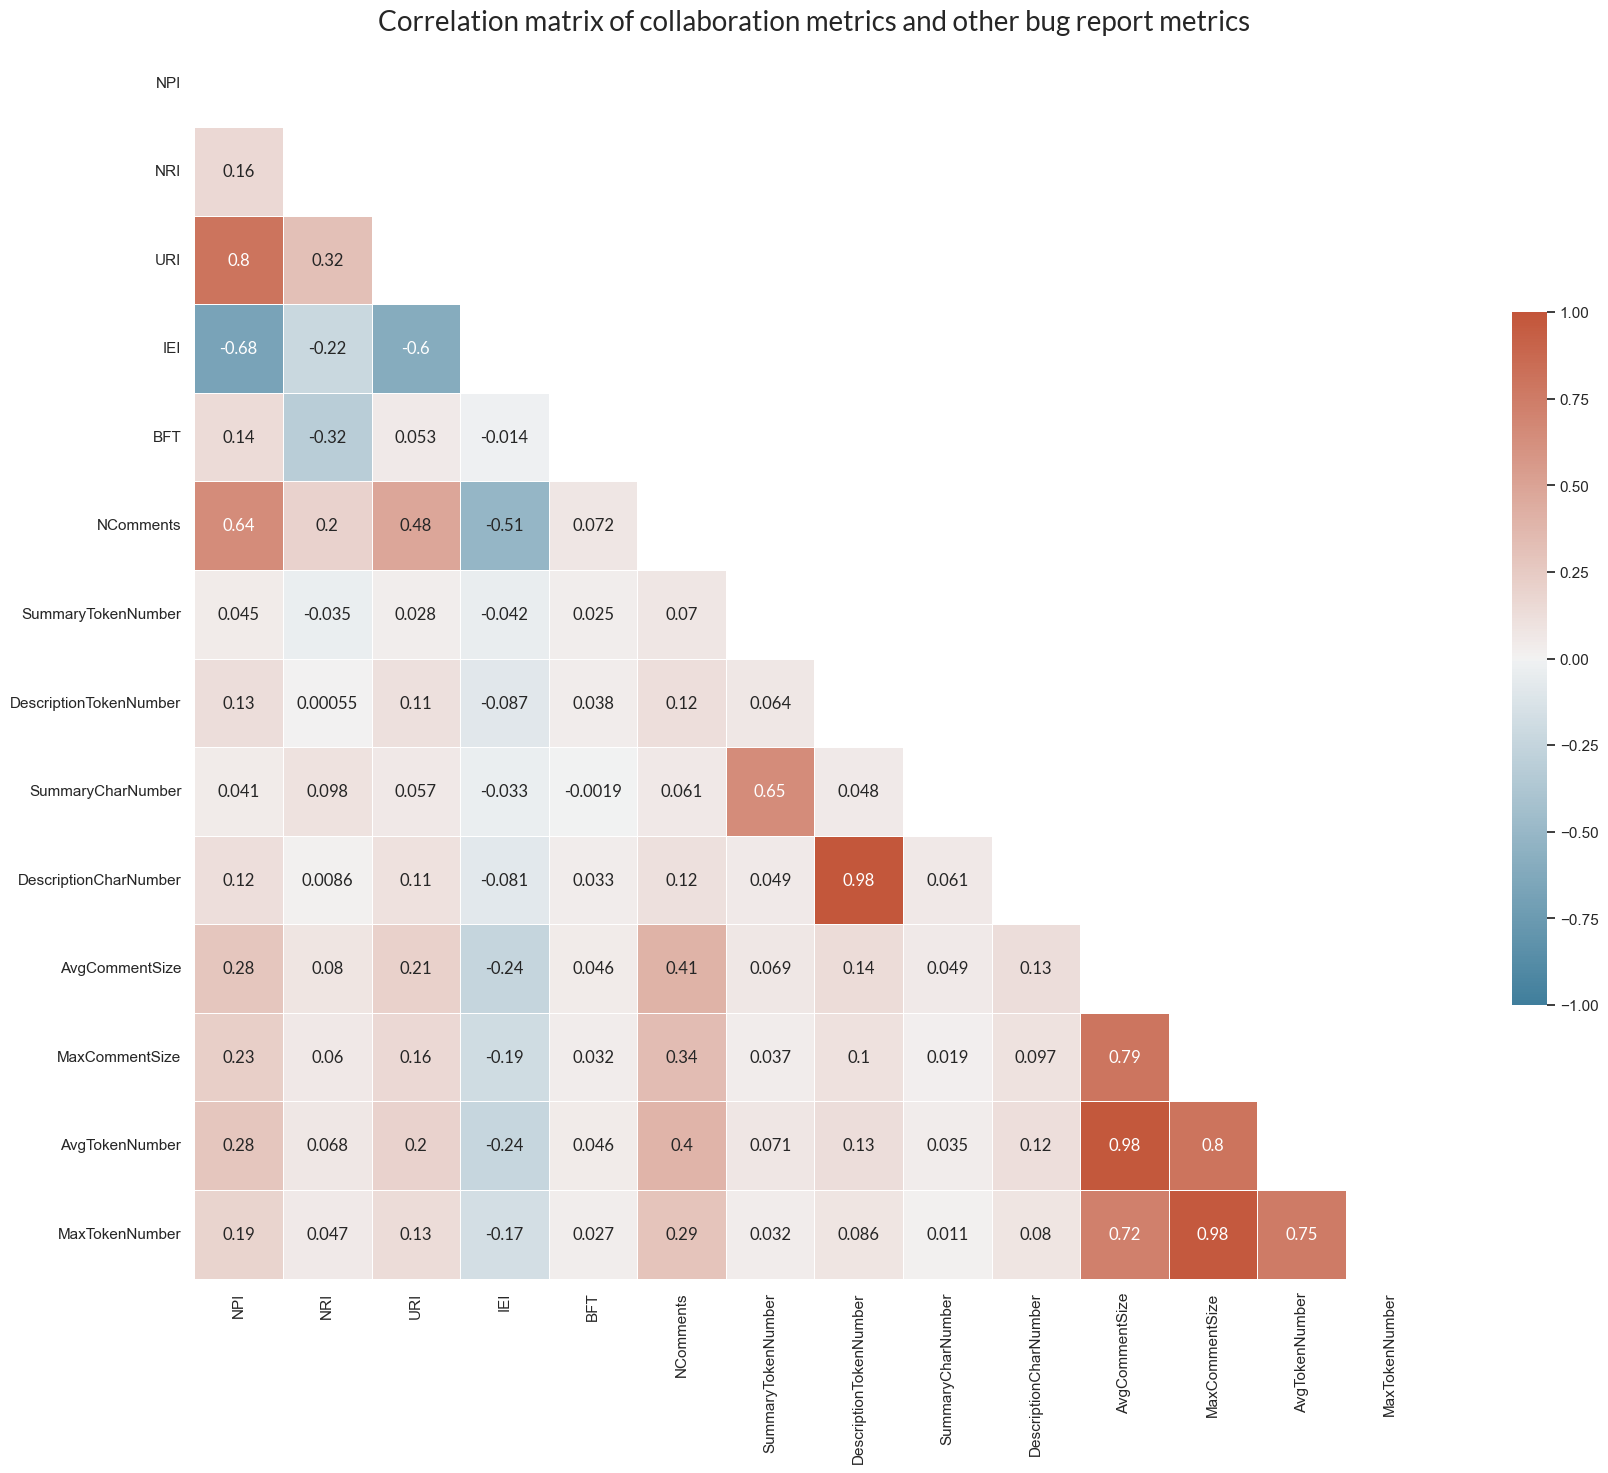

In [78]:
all_metrics_df = collab_summary_df[['NPI', 'NRI', 'URI', 'IEI', 'BFT', 'NComments', 'SummaryTokenNumber', 'DescriptionTokenNumber', 'SummaryCharNumber', 'DescriptionCharNumber', 'AvgCommentSize', 'MaxCommentSize', 'AvgTokenNumber', 'MaxTokenNumber']]

# compute corrleation matrix
corr_p = all_metrics_df.corr()
p_values = all_metrics_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(all_metrics_df.columns))

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_p, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr_p, mask=mask,vmin=-1, vmax=1, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={'fontfamily' : 'Lato'} )

heatmap.set_title('Correlation matrix of collaboration metrics and other bug report metrics', fontdict={'fontsize':20, 'fontfamily' : 'Lato'})

plt.savefig('../visualization/images/all_metrics_pearson_corr.pdf', format='pdf')

In [79]:
p_values

,NPI,NRI,URI,IEI,BFT,NComments,SummaryTokenNumber,DescriptionTokenNumber,SummaryCharNumber,DescriptionCharNumber,AvgCommentSize,MaxCommentSize,AvgTokenNumber,MaxTokenNumber
NPI,0.000000e+00,2.616086e-63,0.000000e+00,0.000000e+00,9.432890e-50,0.000000e+00,5.836988e-06,5.069878e-40,3.391080e-05,1.097951e-35,5.769887e-182,2.535403e-120,1.661307e-180,5.872993e-86
NRI,2.616086e-63,0.000000e+00,1.724445e-242,6.453854e-114,1.042970e-239,1.609334e-90,4.278994e-04,9.551172e-01,2.045680e-23,3.802257e-01,5.136879e-16,9.167865e-10,5.466100e-12,1.360723e-06
URI,0.000000e+00,1.724445e-242,0.000000e+00,0.000000e+00,7.089854e-08,0.000000e+00,4.462317e-03,1.907938e-30,5.915579e-09,5.421851e-28,2.852603e-101,1.351220e-62,3.315452e-95,3.669532e-43
IEI,0.000000e+00,6.453854e-114,0.000000e+00,0.000000e+00,1.572126e-01,0.000000e+00,2.048021e-05,5.029738e-19,9.236801e-04,1.986542e-16,2.004888e-138,1.562447e-87,1.958839e-136,1.230820e-64
BFT,9.432890e-50,1.042970e-239,7.089854e-08,1.572126e-01,0.000000e+00,1.665684e-13,1.116552e-02,1.160703e-04,8.466003e-01,7.561353e-04,3.257557e-06,1.215661e-03,2.418435e-06,5.166325e-03
NComments,0.000000e+00,1.609334e-90,0.000000e+00,0.000000e+00,1.665684e-13,0.000000e+00,7.033160e-13,2.735918e-36,5.311908e-10,6.647619e-32,0.000000e+00,2.966823e-272,0.000000e+00,7.619578e-201
SummaryTokenNumber,5.836988e-06,4.278994e-04,4.462317e-03,2.048021e-05,1.116552e-02,7.033160e-13,0.000000e+00,5.337893e-11,0.000000e+00,5.861171e-07,1.989596e-12,1.486744e-04,4.019664e-13,1.077649e-03
DescriptionTokenNumber,5.069878e-40,9.551172e-01,1.907938e-30,5.029738e-19,1.160703e-04,2.735918e-36,5.337893e-11,0.000000e+00,1.108138e-06,0.000000e+00,8.460091e-44,9.759036e-26,1.236396e-41,2.036265e-18
SummaryCharNumber,3.391080e-05,2.045680e-23,5.915579e-09,9.236801e-04,8.466003e-01,5.311908e-10,0.000000e+00,1.108138e-06,0.000000e+00,4.251358e-10,5.688800e-07,4.938765e-02,3.654243e-04,2.734458e-01
DescriptionCharNumber,1.097951e-35,3.802257e-01,5.421851e-28,1.986542e-16,7.561353e-04,6.647619e-32,5.861171e-07,0.000000e+00,4.251358e-10,0.000000e+00,9.460822e-40,6.822381e-23,1.613066e-36,4.796572e-16


## Analysis 4: Collaboration Diversity and BFT by Priority Group


In [26]:
# Let's create a dataframe for each priority group
trivial_and_minor_df = collab_summary_df[(collab_summary_df['Priority'] == 'Trivial') | (collab_summary_df['Priority'] == 'Minor')]
major_df = collab_summary_df[collab_summary_df['Priority'] == 'Major']
critical_and_blocker_df = collab_summary_df[(collab_summary_df['Priority'] == 'Critical') | (collab_summary_df['Priority'] == 'Blocker')]

In [70]:
low_metrics_df = trivial_and_minor_df[['BFT', 'NPI', 'NRI', 'URI', 'IEI']]
medium_metrics_df = major_df[['BFT', 'NPI', 'NRI', 'URI', 'IEI']]
high_metrics_df = critical_and_blocker_df[['BFT', 'NPI', 'NRI', 'URI', 'IEI']]

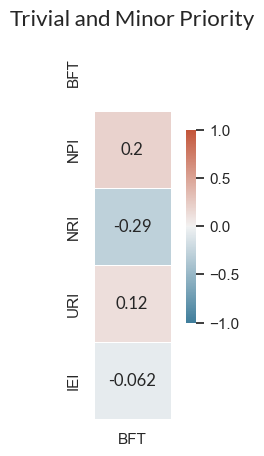

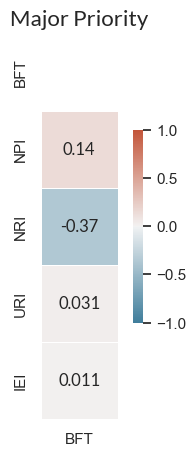

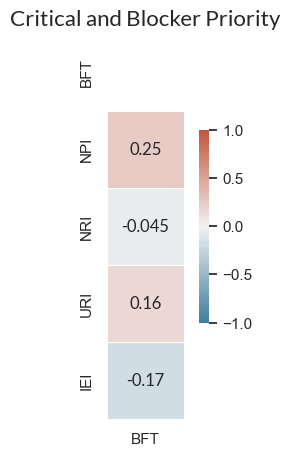

In [77]:
# compute corrleation matrix
dataframes = [low_metrics_df, medium_metrics_df, high_metrics_df]
labels = ['Trivial and Minor Priority', 'Major Priority', 'Critical and Blocker Priority']
p_values_list = {}

for label, df in zip(labels, dataframes):
    corr_p = df.corr()
    corr_p = corr_p['BFT'].to_frame()

    p_values = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(df.columns))
    p_values = p_values['BFT'].to_frame()
    p_values_list[label] = p_values

    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_p, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(4, 5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr_p, mask=mask,vmin=-1, vmax=1, cmap=cmap, center=0,
                              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={'fontfamily' : 'Lato'} )

    heatmap.set_title(label, fontdict={'fontsize':16, 'fontfamily' : 'Lato'})

    plt.savefig(f'../visualization/images/{label}_pearson_corr.pdf', format='pdf')

In [75]:
for each in p_values_list:
    print(each)
    print(p_values_list[each])

Trivial and Minor Priority
              BFT
BFT  0.000000e+00
NPI  2.620514e-20
NRI  2.533815e-42
URI  5.167835e-08
IEI  4.248175e-03
Major Priority
               BFT
BFT   0.000000e+00
NPI   6.669319e-29
NRI  1.572781e-196
URI   1.454254e-02
IEI   3.681080e-01
Critical and Blocker Priority
              BFT
BFT  0.000000e+00
NPI  5.133365e-30
NRI  4.029691e-02
URI  4.113866e-13
IEI  3.666499e-15


Removing outliers


Lower bound:  -1144.8475
Upper bound:  1974.6125000000002
Number of outliers in BFT:  349


Text(0.5, 1.0, 'Correlation matrix of collaboration metrics without outliers, Trivial and Minor Priority')

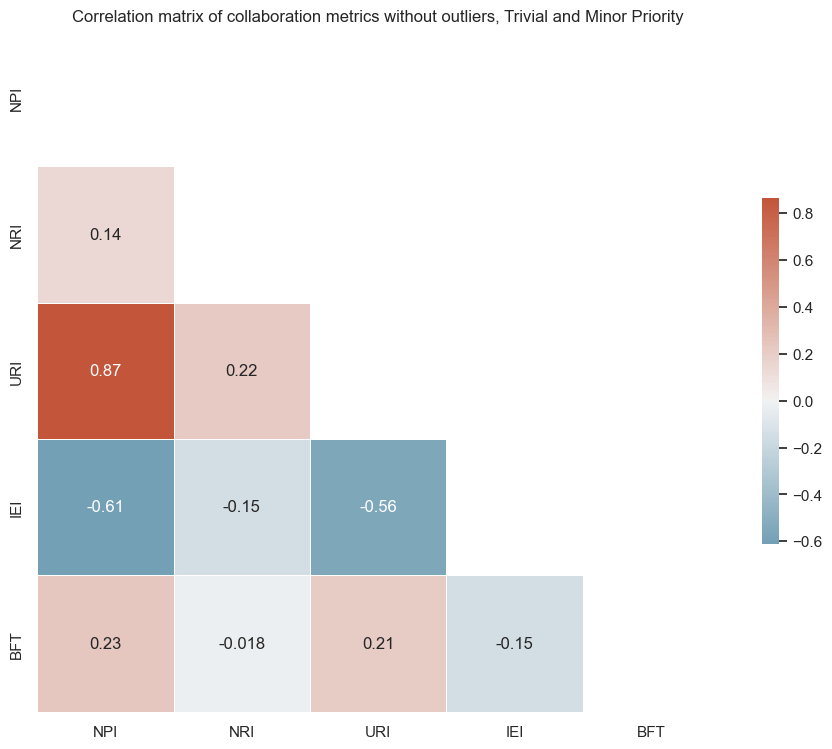

In [24]:
#calculate interquartile range 
q3, q1 = np.percentile(low_metrics_df['BFT'], [75 ,25])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

low_metrics_filtered_df = low_metrics_df[(low_metrics_df['BFT'] > lower_bound) & (low_metrics_df['BFT'] < upper_bound)]
print("Number of outliers in BFT: ", len(low_metrics_df) - len(low_metrics_filtered_df))

# compute corrleation matrix
corr_p = low_metrics_filtered_df.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_p, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr_p, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

heatmap.set_title('Correlation matrix of collaboration metrics without outliers, Trivial and Minor Priority')

Lower bound:  -1433.8937499999997
Upper bound:  2512.0762499999996
Number of outliers in BFT:  959


Text(0.5, 1.0, 'Correlation matrix of collaboration metrics without outliers, Major Priority')

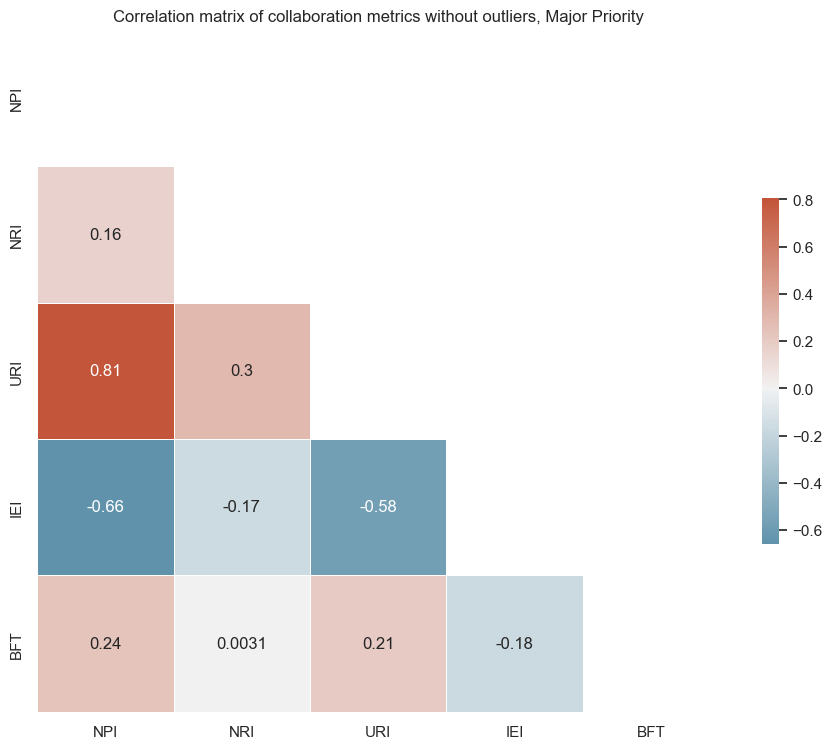

In [25]:
#calculate interquartile range 
q3, q1 = np.percentile(medium_metrics_df['BFT'], [75 ,25])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

medium_metrics_filtered_df = medium_metrics_df[(medium_metrics_df['BFT'] > lower_bound) & (medium_metrics_df['BFT'] < upper_bound)]
print("Number of outliers in BFT: ", len(medium_metrics_df) - len(medium_metrics_filtered_df))

# compute corrleation matrix
corr_p = medium_metrics_filtered_df.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_p, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr_p, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

heatmap.set_title('Correlation matrix of collaboration metrics without outliers, Major Priority')

Lower bound:  -1029.73
Upper bound:  1839.79
Number of outliers in BFT:  287


Text(0.5, 1.0, 'Correlation matrix of collaboration metrics without outliers, Critical and Blocker Priority')

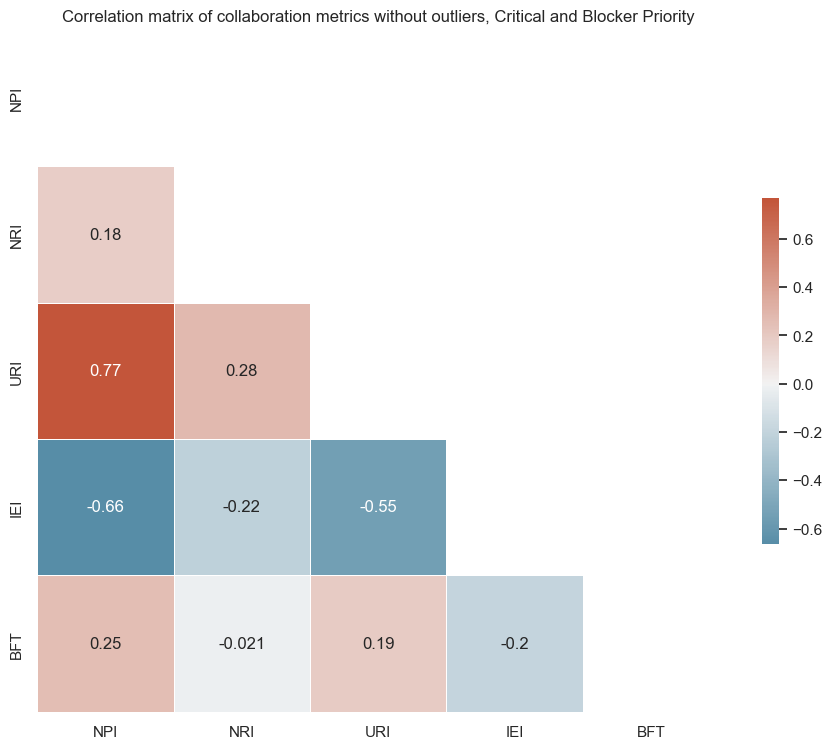

In [26]:
#calculate interquartile range 
q3, q1 = np.percentile(high_metrics_df['BFT'], [75 ,25])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

high_metrics_filtered_df = high_metrics_df[(high_metrics_df['BFT'] > lower_bound) & (high_metrics_df['BFT'] < upper_bound)]
print("Number of outliers in BFT: ", len(high_metrics_df) - len(high_metrics_filtered_df))

# compute corrleation matrix
corr_p = high_metrics_filtered_df.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_p, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr_p, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

heatmap.set_title('Correlation matrix of collaboration metrics without outliers, Critical and Blocker Priority')


## Analysis 5: Collaboration Diversity and BFT Through time

The code below generates a correlation matrix for every two years in the dataset.

Year:  2009
Year:  2011
Year:  2013
Year:  2015
Year:  2017


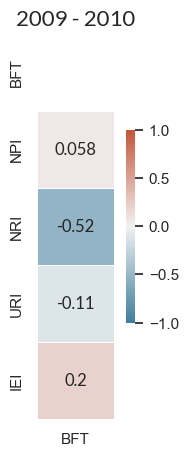

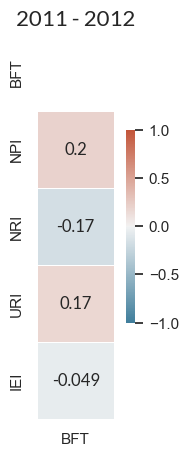

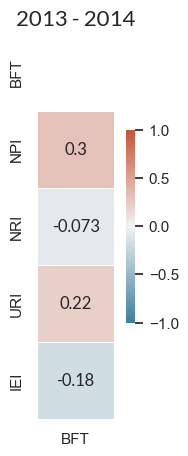

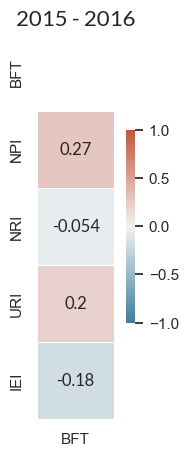

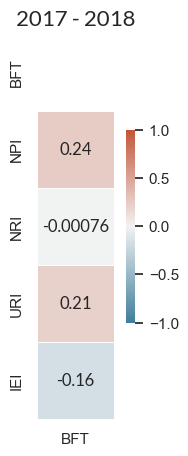

In [66]:
# Let's add a year column to the dataset
collab_summary_df['Year'] = collab_summary_df['BugReportCreationDate'].apply(lambda x: x.split('-')[0])
collab_summary_df['Year'] = collab_summary_df['Year'].astype(int)
collab_summary_df.describe()
initialYear = collab_summary_df['Year'].min()
finalYear = collab_summary_df['Year'].max()

year_p_values = {}

year = initialYear
while year <= finalYear:
    print("Year: ", year)
    year_df = collab_summary_df[(collab_summary_df['Year'] >= year) & (collab_summary_df['Year'] <= year + 1)]
    year_df = year_df[['BFT', 'NPI', 'NRI', 'URI', 'IEI']]
    year_df.describe()

    # compute corrleation matrix
    corr_p = year_df.corr()
    corr_p = corr_p['BFT'].to_frame()

    p_values = year_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(year_df.columns))
    p_values = p_values['BFT'].to_frame()
    year_p_values[year] = p_values

    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_p, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(3, 5))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr_p, mask=mask, vmin=-1, vmax=1, cmap=cmap, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={'fontfamily' : 'Lato'} )

    # heatmap.set_title('Correlation matrix of collaboration metrics and BFT ('+ str(year) + ' - ' + str(year + 1) + ')', fontdict={'fontsize':16, 'fontfamily' : 'Lato'})
    heatmap.set_title(str(year) + ' - ' + str(year + 1), fontdict={'fontsize':16, 'fontfamily' : 'Lato'})

    plt.savefig('../visualization/images/diversity_bft_pearson_corr%d_%d.pdf'%(year,year+1), format='pdf')

    year += 2




In [67]:
for each in year_p_values:
    print("Year: ", each)
    print(year_p_values[each])

Year:  2009
               BFT
BFT   0.000000e+00
NPI   2.930811e-02
NRI  6.808166e-102
URI   2.884205e-05
IEI   4.771983e-14
Year:  2011
              BFT
BFT  0.000000e+00
NPI  1.732055e-23
NRI  5.788752e-17
URI  1.310727e-17
IEI  1.566573e-02
Year:  2013
              BFT
BFT  0.000000e+00
NPI  5.770863e-55
NRI  2.320196e-04
URI  1.067031e-29
IEI  9.684593e-21
Year:  2015
              BFT
BFT  0.000000e+00
NPI  5.576018e-39
NRI  1.029030e-02
URI  6.716340e-22
IEI  1.139140e-17
Year:  2017
              BFT
BFT  0.000000e+00
NPI  5.798710e-23
NRI  9.750627e-01
URI  1.854173e-18
IEI  1.783627e-11
